In [33]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from scipy.constants import R

RT = 300 * R * 1e-3

Load the data

In [34]:
df_metad = plumed.read_as_pandas('data/metad.COLVAR')
df_static = plumed.read_as_pandas('data/static.COLVAR')
df_fes = plumed.read_as_pandas('data/fes.dat')

# Rescaling factor for "nicer" integral values of the coordination numbers
scale = 1.039661

/tmp/ipykernel_1277/805837264.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  df_metad = plumed.read_as_pandas('data/metad.COLVAR')
/tmp/ipykernel_1277/805837264.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  df_static = plumed.read_as_pandas('data/static.COLVAR')
/tmp/ipykernel_1277/805837264.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  df_fes = plumed.read_as_pandas('data/fes.dat')


### Timeseries

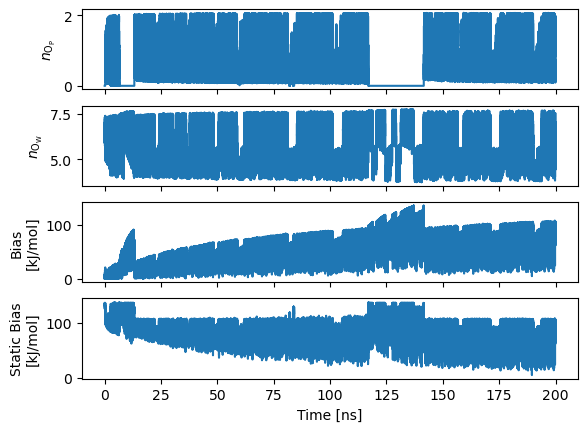

In [35]:
fig, axarr = plt.subplots(nrows=4, sharex=True)

ax = axarr[0]
ax.plot(df_metad.time / 1000, df_metad.nop * scale)
ax.set_ylabel(r"$n_\mathrm{O_P}$")

ax = axarr[1]
ax.plot(df_metad.time / 1000, df_metad.now * scale)
ax.set_ylabel(r"$n_\mathrm{O_W}$")

ax = axarr[2]
ax.plot(df_metad.time / 1000, df_metad['metad.bias'])
ax.set_ylabel("Bias\n[kJ/mol]")

ax = axarr[3]
ax.plot(df_static.time / 1000, df_static['metad.bias'])
ax.set_ylabel("Static Bias\n[kJ/mol]")
ax.set_xlabel("Time [ns]")

plt.savefig('figures/metad_timeseries.png')

### FES

In [36]:
nop_range = df_fes.nop.unique() * scale
now_range = df_fes.now.unique() * scale
fes_hills = df_fes['file.free'].array.reshape(now_range.size, nop_range.size)
fes_hills -= fes_hills.min()

In [37]:
weights = np.exp(df_static['metad.bias'] / RT)
nop_edges = np.linspace(nop_range[0], nop_range[-1], 50)
now_edges = np.linspace(now_range[0], now_range[-1], 50)
density, _, _ = np.histogram2d(df_metad.nop * scale, df_metad.now * scale, bins=(nop_edges, now_edges), density=True, weights=weights)
fes = -RT * np.log(density)
fes -= fes.min()

levels = np.arange(0, 60, RT)

/tmp/ipykernel_1277/1996555635.py:5: RuntimeWarning: divide by zero encountered in log
  fes = -RT * np.log(density)


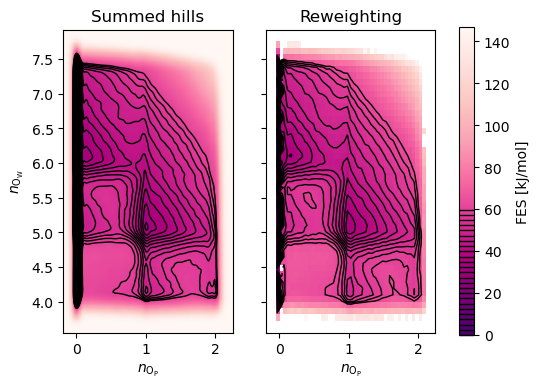

In [38]:
fig, axarr = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6, 4))

ax = axarr[0]
im = ax.imshow(fes_hills, origin='lower', extent=[nop_range[0], nop_range[-1], now_range[0], now_range[-1]], cmap='RdPu_r')
contour = ax.contour(nop_range, now_range, fes_hills, levels=levels, colors='black', linestyles='solid', linewidths=1)
ax.set_title("Summed hills")
ax.set_xlabel(r"$n_\mathrm{O_P}$")
ax.set_ylabel(r"$n_\mathrm{O_W}$")

ax = axarr[1]
ax.imshow(fes.T, origin='lower', extent=[nop_range[0], nop_range[-1], now_range[0], now_range[-1]], cmap='RdPu_r')
contour = ax.contour(fes.T, extent=[nop_range[0], nop_range[-1], now_range[0], now_range[-1]], levels=levels, colors='black', linestyles='solid', linewidths=1)
ax.set_title("Reweighting")
ax.set_xlabel(r"$n_\mathrm{O_P}$")

cbar = plt.colorbar(im, ax=axarr.ravel())
cbar.add_lines(contour)
cbar.ax.set_ylabel("FES [kJ/mol]")

plt.savefig('figures/metad_fes.png')